In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
# We also set some seeds to make this reproducable.
np.random.seed(42)
_ = torch.manual_seed(42)

## Dataset


In [3]:
df_train_x = pd.read_csv('train_x.csv')
df_train_y = pd.read_csv('train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv('test_x.csv')
df_test_y = pd.read_csv('test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [10]:
cols_standardize =  ['BE', 'BC', 'AQ', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC', 'DT',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AY', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

22


In [11]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [12]:
df_train.head()

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DE,DT,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
0,0.0,1.0,2.0,2.0,6.7,3.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,75.0,1.0,1.0,1.0,363.0
3,0.0,1.0,4.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,...,2.0,1.0,1.0,1.0,1.0,65.0,1.0,1.0,0.0,10000.0
4,1.0,1.0,2.0,3.0,3.5,3.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,75.0,1.0,1.0,1.0,347.0
5,1.0,1.0,2.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,79.0,1.0,1.0,1.0,13.0
9,1.0,1.0,2.0,3.0,1.9,3.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,29.0,1.0,1.0,0.0,334.0


In [15]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [16]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [17]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [18]:
get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural Network

In [19]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [20]:
num_embeddings, embedding_dims

(array([3, 4], dtype=int64), array([1, 2], dtype=int64))

In [56]:
in_features = x_train[0].shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [57]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=23, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

## Training the model

In [74]:
model = CoxPH(net, tt.optim.Adam)

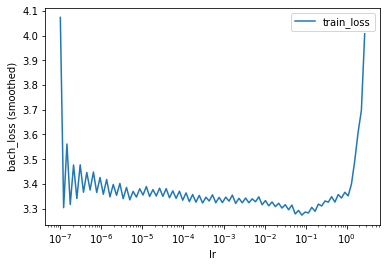

In [75]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [76]:
lrfinder.get_best_lr()

0.007924828983539215

In [77]:
model.optimizer.set_lr(0.01)

In [81]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [82]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

32:	[0s / 0s],		train_loss: 3.1007,	val_loss: 2.8922
33:	[0s / 0s],		train_loss: 3.1005,	val_loss: 2.9016
34:	[0s / 0s],		train_loss: 2.8957,	val_loss: 2.9382
35:	[0s / 0s],		train_loss: 2.7225,	val_loss: 2.9724
36:	[0s / 0s],		train_loss: 2.7684,	val_loss: 2.9988
37:	[0s / 0s],		train_loss: 2.8201,	val_loss: 3.0143
38:	[0s / 0s],		train_loss: 2.7995,	val_loss: 3.0480
39:	[0s / 0s],		train_loss: 2.8174,	val_loss: 3.0362
40:	[0s / 0s],		train_loss: 2.7231,	val_loss: 3.0019
41:	[0s / 0s],		train_loss: 2.8347,	val_loss: 2.9700
42:	[0s / 0s],		train_loss: 2.6970,	val_loss: 2.9546
Wall time: 160 ms


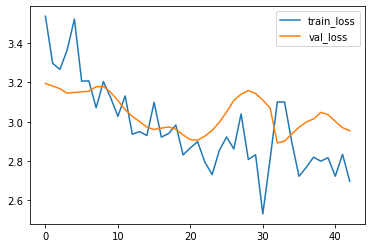

In [83]:
_ = log.plot()

We can get the partial log-likelihood

In [84]:
model.partial_log_likelihood(*val).mean()

-2.8978379

## Prediction

In [85]:
_ = model.compute_baseline_hazards()

In [86]:
surv = model.predict_surv_df(x_test)

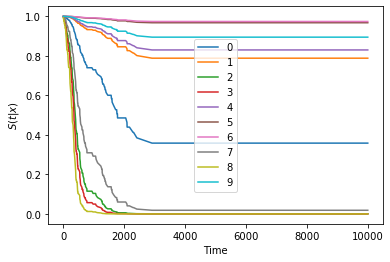

In [102]:
surv.iloc[:, 0:10].plot()
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [88]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [89]:
ev.concordance_td()

0.7996511881403968

In [92]:
durations_train, events_train = get_target(df_train)

In [94]:
surv_train = model.predict_surv_df(x_train)

In [95]:
ev_cdi_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')

In [96]:
ev_cdi_train.concordance_td()

0.9218843172331544

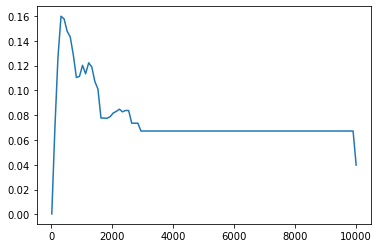

In [90]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [97]:
ev.integrated_brier_score(time_grid)

0.07679362841334691

In [98]:
ev_cdi_train.integrated_brier_score(time_grid)

0.034155935467170086